In [315]:
# basic imports
import numpy as np
import pandas as pd
from time import time

# demos for visualization
from nilearn import datasets
from nilearn import plotting
from nilearn.connectome import GroupSparseCovariance
from nilearn.connectome import ConnectivityMeasure

import matplotlib.pyplot as plt

# for ML
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.decomposition import KernelPCA
from sklearn import ensemble

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader

# os library
from os.path import exists, join

np.random.seed(1679838)
torch.manual_seed(1679838)

In [316]:
data_path = join(".", "data") if exists(join(".", "data")) \
    else join("..", "input", "statistical-learning-sapienza-spring-2021")

In [317]:
train = pd.read_csv(join(data_path, 'train.csv'))

In [381]:
roi_indices = ['Frontal' in x for x in pd.read_csv(join('.', 'data', 'coordinates.txt'), sep = ' ')['Abbreviation']]

In [428]:
pd.read_csv(join('.', 'data', 'coordinates.txt'), sep = ' ')['Abbreviation'].values

array(['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R',
       'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L',
       'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R',
       'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L',
       'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R',
       'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L',
       'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R',
       'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R',
       'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R',
       'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R',
       'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L',
       'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R',
       'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L',
       'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R',
       'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R',
   

### Splitting

In [429]:
y_train = train.loc[:,'y']
X_train = train.drop(columns=['y'])
X_train.loc[:, 'var2'] = X_train.loc[:, 'var2'] == 'A'
X_train.loc[:, 'var3'] = X_train.loc[:, 'var3'] == 'A'

In [430]:
from sklearn.decomposition import PCA
mean_ts_train = X_train.iloc[:,4:].apply(np.mean, axis=0).to_numpy().reshape(115, 116)
pca_model = PCA(n_components=0.9, svd_solver='full')
pca_model.fit(mean_ts_train)


PCA(n_components=0.9, svd_solver='full')

In [431]:
def get_data(entry):
    variables = entry[['var1', 'var2', 'var3']].to_numpy()
    timeseries = entry[5 if "y" in entry.index else 4:].to_numpy(dtype=float).reshape((115, 116), order="F")
    # timeseries = timeseries[:, roi_indices]
    return {"variables": variables, "timeseries": timeseries}

train_timeseries = X_train.apply(lambda row: pca_model.transform(get_data(row)["timeseries"]), axis=1).to_list()

In [433]:
variables = train[['var1', 'var2', 'var3']]
variables.loc[:, 'var2'] = vars.loc[:, 'var2'] == 'A'
variables.loc[:, 'var3'] = vars.loc[:, 'var3'] == 'A'

C:\Users\simon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Correlation matrices and PCA


In [432]:
import nitime.timeseries as ts
time_series = list(map(lambda x: ts.TimeSeries(x.T, sampling_interval=1), train_timeseries))

import nitime.analysis as nta
import time
start = time.time()
f_ub = 0.15
f_lb = 0.02
causalities = []
for i, x in enumerate(time_series):
    if i%60 == 0:
        print(f'{i/6}% done in {round(time.time() - start, 2)} seconds')
    G=nta.GrangerAnalyzer(x, order=1)
    freq_idx_G = np.where((G.frequencies > f_lb) * (G.frequencies < f_ub))[0]
    g1 = np.mean(G.causality_xy[:, :, freq_idx_G], -1)
    causalities.append(g1)
print(f'Granger Analysis done in {round((time.time() - start)/60, 2)} minutes')

for c in causalities:
    c[np.isnan(c)] = 0


0.0% done in 0.0 seconds
10.0% done in 21.56 seconds
20.0% done in 45.86 seconds
30.0% done in 67.25 seconds
40.0% done in 88.82 seconds
50.0% done in 110.86 seconds
60.0% done in 132.42 seconds
70.0% done in 154.43 seconds
80.0% done in 175.19 seconds
90.0% done in 198.22 seconds
Granger Analysis done in 3.66 minutes


C:\Users\simon\Anaconda3\lib\site-packages\nitime\algorithms\autoregressive.py:523: RuntimeWarning: invalid value encountered in log
  f_xy = np.log(f_xy)
C:\Users\simon\Anaconda3\lib\site-packages\nitime\algorithms\autoregressive.py:509: RuntimeWarning: invalid value encountered in log
  f_x_on_y = np.log(Syy.real / yy_auto_component)
C:\Users\simon\Anaconda3\lib\site-packages\nitime\algorithms\autoregressive.py:499: RuntimeWarning: invalid value encountered in log
  f_y_on_x = np.log(Sxx.real / xx_auto_component)


In [438]:
X_train = np.hstack([variables, np.vstack(list(map(lambda x: np.abs(x.flatten())>0.25, causalities)))])


In [435]:
X_train

array([[19, False, False, ..., False, False, False],
       [14, False, False, ..., False, False, False],
       [13, False, False, ..., False, False, False],
       ...,
       [27, False, False, ..., False, False, False],
       [29, False, False, ..., False, False, False],
       [26, False, False, ..., False, False, False]], dtype=object)

In [358]:
# def apply_connectivity(time_series, vect=True, diag=True):
#     # objects:
#     correlation_measure = ConnectivityMeasure(kind='partial correlation',
#                                               vectorize = vect,
#                                               discard_diagonal=diag)
#     
#     
# 
#     # fitting predicting:
#     return correlation_measure.fit_transform(time_series)
#     # pca_model.fit(cor_mat)
# 
# train_cor_vec = apply_connectivity(train_timeseries)
# val_cor_vec = apply_connectivity(val_timeseries)
# 



In [439]:
from sklearn.model_selection import RandomizedSearchCV

#model 
model = svm.SVR(max_iter=10000)
#cross validation with random search model
params = dict(kernel=['linear', 'poly', 'rbf', 'sigmoid'],
              degree=[2,3,4],
              C=[0.1, 0.5, 1.0, 1.5, 2, 3, 5, 10, 30, 50],
              gamma= ['auto', 'scale'],
              shrinking = [True, False]
             )
reg = RandomizedSearchCV(estimator = model, param_distributions = params,
                                   scoring = 'neg_root_mean_squared_error',
                                   n_iter = 150,
                                   cv = 4, n_jobs = -1)
random_search = reg.fit(X_train, y_train)

print(f'best params: {random_search.best_params_}')
print(f'best score: {random_search.best_score_}')

best params: {'shrinking': True, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'C': 0.1}
best score: -14.632556842843966


In [440]:
from sklearn.metrics import mean_squared_error
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_train)
print(f'best train score {-mean_squared_error(y_train, y_pred, squared=False)}')

best train score -14.701335639866363


In [442]:
test = pd.read_csv(join('.', 'data', 'test.csv'))
test.loc[:, 'var2'] = test.loc[:, 'var2'] == 'A'
test.loc[:, 'var3'] = test.loc[:, 'var3'] == 'A'

test_timeseries = test.apply(lambda row: pca_model.transform(get_data(row)["timeseries"]), axis=1).to_list()


In [414]:
test_timeseries[0].shape

(115, 18)

In [443]:
test_timeseries = list(map(lambda x: ts.TimeSeries(x.T, sampling_interval=1), test_timeseries))

start = time.time()
f_ub = 0.15
f_lb = 0.02
test_causalities = []
for i, x in enumerate(test_timeseries):
    if i%60 == 0:
        print(f'{i/6}% done in {round(time.time() - start, 2)} seconds')
    G=nta.GrangerAnalyzer(x, order=1)
    freq_idx_G = np.where((G.frequencies > f_lb) * (G.frequencies < f_ub))[0]
    g1 = np.mean(G.causality_xy[:, :, freq_idx_G], -1)
    test_causalities.append(g1)
print(f'Granger Analysis done in {round((time.time() - start)/60, 2)} minutes')

for c in test_causalities:
    c[np.isnan(c)] = 0

0.0% done in 0.0 seconds
10.0% done in 21.68 seconds
20.0% done in 45.04 seconds
30.0% done in 65.62 seconds
Granger Analysis done in 1.21 minutes


C:\Users\simon\Anaconda3\lib\site-packages\nitime\algorithms\autoregressive.py:523: RuntimeWarning: invalid value encountered in log
  f_xy = np.log(f_xy)
C:\Users\simon\Anaconda3\lib\site-packages\nitime\algorithms\autoregressive.py:499: RuntimeWarning: invalid value encountered in log
  f_y_on_x = np.log(Sxx.real / xx_auto_component)
C:\Users\simon\Anaconda3\lib\site-packages\nitime\algorithms\autoregressive.py:509: RuntimeWarning: invalid value encountered in log
  f_x_on_y = np.log(Syy.real / yy_auto_component)


In [444]:
X_test = np.hstack([test[['var1', 'var2', 'var3']], np.vstack(list(map(lambda x: np.abs(x.flatten())>0.25, test_causalities)))])


In [445]:

prediction = best_model.predict(X_test)

In [446]:
submission = pd.concat([test['id'], pd.Series(prediction, name='target')], axis=1)

In [447]:
submission.to_csv('submission_granger_pca.csv', index=False)

In [61]:
train_var_and_cor = pd.concat([pd.DataFrame(train_variables).add_prefix('var_'), train_cor_vec], axis=1)
val_var_and_cor = pd.concat([pd.DataFrame(val_variables).add_prefix('var_'), val_cor_vec], axis=1)


### Data loaders

In [62]:
def get_dataloader(timeseries, variables_correlation, labels):
    return DataLoader(TensorDataset(torch.Tensor(timeseries),torch.Tensor(variables_correlation),
                                    torch.Tensor(labels)), batch_size=10) # create your dataloader

train_dataloader = get_dataloader(train_timeseries, np.array(train_variables), train_split.y.to_numpy())
val_dataloader = get_dataloader(val_timeseries, np.array(val_variables), val_split.y.to_numpy())

## Model

In [67]:
class BlackEmbedding(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.rnn_model = nn.RNN(input_size=119, hidden_size=hidden_size, num_layers=num_layers, dropout=0.05, batch_first=True)
        self.fc1 = nn.Linear(3+(hidden_size*(1+num_layers)), 32)
        self.fc2 = nn.Linear(32, 32)
        self.regressor = nn.Linear(32, 1)
        self.activation = nn.ReLU()

    def forward(self, x, var_and_cor, predict_anyway=False):
        x = torch.cat([x, np.repeat(var_and_cor[:, np.newaxis,:], 115, axis=1)], dim=-1)
        outputs, hidden = self.rnn_model(x)

        hidden = torch.cat(list(map(lambda i: hidden[i, ], range(hidden.shape[0]))), dim=-1)

        x = torch.cat([var_and_cor, outputs[:, -1, ], hidden], dim=-1)  # taking only the last

        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))

        if self.training or predict_anyway:
            x = self.regressor(x)

        return x.squeeze(dim=1)

model = BlackEmbedding(hidden_size=64, num_layers=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
criterion = nn.MSELoss()



## Training

In [69]:
epocs = 20
rmse = {"train": [], "val": []}

start = time()
for epoch in range(epocs):
    model.train()
    rmse["train"].append(0)
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, var_and_cor, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs, var_and_cor)

        # forward + backward + optimize
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        rmse["train"][epoch] += loss.sqrt().mean(dim=0)/len(train_dataloader)

    # validation
    model.eval()

    rmse["val"].append(0)
    for i, data in enumerate(val_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, var_and_cor, labels = data
        with torch.no_grad():
            outputs = model(inputs, var_and_cor, predict_anyway=True)

        # forward + backward + optimize
        rmse["val"][epoch] += criterion(outputs, labels).sqrt().mean(dim=0)/len(val_dataloader)
    print(f"\n------> Epoch {epoch+1} <------\n    Train RMSE loss: {rmse['train'][epoch]}\n    Val   RMSE loss: {rmse['val'][epoch]}")

print('\n\n****************** Finished Training ******************')
print("seconds elapsed: ", time()-start)



------> Epoch 1 <------
    Train RMSE loss: 14.134319305419922
    Val   RMSE loss: 15.566473007202148

------> Epoch 2 <------
    Train RMSE loss: 14.133048057556152
    Val   RMSE loss: 15.513832092285156

------> Epoch 3 <------
    Train RMSE loss: 14.113158226013184
    Val   RMSE loss: 15.47895622253418

------> Epoch 4 <------
    Train RMSE loss: 14.083061218261719
    Val   RMSE loss: 15.45009994506836

------> Epoch 5 <------
    Train RMSE loss: 14.05765151977539
    Val   RMSE loss: 15.367844581604004

------> Epoch 6 <------
    Train RMSE loss: 13.992067337036133
    Val   RMSE loss: 15.346684455871582

------> Epoch 7 <------
    Train RMSE loss: 13.944612503051758
    Val   RMSE loss: 15.32274055480957

------> Epoch 8 <------
    Train RMSE loss: 13.883169174194336
    Val   RMSE loss: 15.29275894165039

------> Epoch 9 <------
    Train RMSE loss: 13.801652908325195
    Val   RMSE loss: 15.26380729675293

------> Epoch 10 <------
    Train RMSE loss: 13.79898738861

In [51]:
inputs.shape

torch.Size([10, 115, 116])

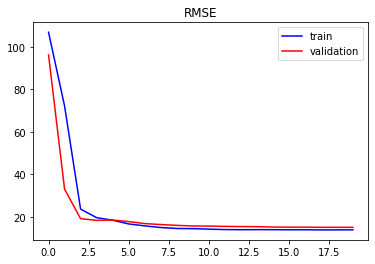

In [14]:
plt.plot(range(len(rmse["train"])), rmse["train"], color="blue", label="train")
plt.plot(range(len(rmse["val"])), rmse["val"], color="red", label="validation")
plt.title("RMSE")
plt.legend()
plt.show()

In [174]:
train_embedding = model.forward(torch.Tensor(train_timeseries))
val_embedding = model.forward(torch.Tensor(val_timeseries))

In [175]:
train_embedding_df = pd.concat([train_split.iloc[:, 2:4], pd.DataFrame(train_embedding.detach().numpy(), index=train_split.index)], axis=1)
val_embedding_df = pd.concat([val_split.iloc[:, 2:4], pd.DataFrame(val_embedding.detach().numpy(), index=val_split.index)], axis=1)

In [176]:
train_embedding_df.var2 = train_embedding_df.var2.replace({"A": 0, "C": 1})
val_embedding_df.var2 = val_embedding_df.var2.replace({"A": 0, "C": 1})

In [177]:
X_train, X_val = train_embedding_df.to_numpy(), val_embedding_df.to_numpy()
y_train, y_val = train_split.y.to_numpy(), val_split.y.to_numpy()

In [178]:
svm_model = svm.SVR(shrinking=True, kernel="sigmoid", gamma="scale", degree=4, C=0.5)

svm_model.fit(X_train, y_train)

SVR(C=0.5, degree=4, kernel='sigmoid')

In [179]:
y_ped_train = svm_model.predict(X_train)
y_ped_val = svm_model.predict(X_val)

In [180]:
print(f"train : {np.sqrt(mean_squared_error(y_ped_train, y_train))} \nval  : {np.sqrt(mean_squared_error(y_ped_val, y_val))}")

train : 14.46731332919218 
val  : 16.120551887566872


In [181]:
pd.DataFrame(val_embedding.detach().numpy(), index=val_split.index)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
110,0.000000,0.0,33.637390,0.000000,33.896420,0.0,30.615675,31.881088,31.626308,0.0,...,28.560516,0.0000,33.136833,0.0,30.388554,31.317009,30.641258,29.553339,0.0,0.000000
419,0.000000,0.0,33.666306,0.000000,33.922497,0.0,30.645451,31.905592,31.652485,0.0,...,28.585737,0.0000,33.165642,0.0,30.417480,31.347656,30.668304,29.575769,0.0,0.000000
565,0.000000,0.0,33.663048,0.000000,33.919193,0.0,30.641996,31.902082,31.648861,0.0,...,28.582979,0.0000,33.162563,0.0,30.414177,31.344082,30.664511,29.572756,0.0,0.000000
77,0.000000,0.0,25.453283,0.000000,26.474634,0.0,23.194553,24.252129,24.933500,0.0,...,21.665619,0.2713,25.743305,0.0,22.891548,24.141226,23.771708,22.632118,0.0,0.032363
181,0.000000,0.0,33.622978,0.000000,33.884037,0.0,30.611977,31.857613,31.602100,0.0,...,28.555353,0.0000,33.120586,0.0,30.365826,31.302959,30.623489,29.535894,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.000000,0.0,33.666332,0.000000,33.922523,0.0,30.645472,31.905622,31.652496,0.0,...,28.585690,0.0000,33.165638,0.0,30.417484,31.347687,30.668293,29.575781,0.0,0.000000
340,0.000000,0.0,33.666298,0.000000,33.922527,0.0,30.645456,31.905621,31.652515,0.0,...,28.585758,0.0000,33.165642,0.0,30.417496,31.347713,30.668343,29.575809,0.0,0.000000
148,0.042667,0.0,32.572865,0.100658,32.659508,0.0,29.666977,30.599995,30.702549,0.0,...,27.752827,0.0000,32.023682,0.0,29.502060,30.236879,29.531418,28.562664,0.0,0.000000
494,0.000000,0.0,33.655487,0.000000,33.915691,0.0,30.638044,31.897831,31.643623,0.0,...,28.577787,0.0000,33.156681,0.0,30.407158,31.340368,30.659786,29.570171,0.0,0.000000


In [182]:
test = pd.read_csv(join(data_path, 'test.csv'))
time_series_test = test.apply(lambda row: get_data(row)[-1], axis=1).to_list()

In [183]:
predictions = model.forward(torch.Tensor(time_series_test), predict_anyway=True)

In [62]:
test_embedding_df = pd.concat([test.iloc[:, 2:4], pd.DataFrame(test_embedding.detach().numpy(), index=test.index)], axis=1)

In [133]:
val_pred

tensor([[106.7174],
        [106.8461],
        [106.8462],
        [ 40.6383],
        [106.8414],
        [106.8447],
        [106.8461],
        [ 97.3616],
        [ 35.5079],
        [106.8461],
        [ 93.9863],
        [106.8318],
        [-39.6860],
        [106.8460],
        [106.8461],
        [106.8429],
        [106.8459],
        [106.8445],
        [106.8419],
        [-19.4348],
        [106.8454],
        [106.8446],
        [106.8400],
        [106.8461],
        [106.8461],
        [106.8448],
        [-38.0568],
        [106.6906],
        [106.8460],
        [106.8461],
        [106.8459],
        [ 97.5422],
        [ 21.0665],
        [106.8434],
        [106.8444],
        [106.8461],
        [101.3131],
        [106.8457],
        [106.8461],
        [106.8458],
        [106.8461],
        [106.8453],
        [106.8457],
        [106.8460],
        [106.8461],
        [106.8441],
        [ 14.8656],
        [106.3747],
        [ 20.8572],
        [106.8396],


In [67]:
y_ped_val = model.forward(torch.Tensor(val_timeseries), predict_anyway=True)